In [16]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
from nltk.translate import gleu_score
import pandas as pd
from tqdm.auto import tqdm, trange
from gramformer import Gramformer
import torch

def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(1212)
gf = Gramformer(models = 1, use_gpu=True)
# Usage
opro = OPRO(["gemini", "gemma", "llama2", "anthropic"])
# dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
# CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT = 'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text.'  # somewhere in promptset. Will find idx later
CHOSEN_PROMPT = CHOSEN_PROMPT + " {TEXT}"
CHOSEN_PROMPT

/home/dpaul/.local/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/dpaul/.local/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/dpaul/.local/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


[Gramformer] Grammar error correct/highlight model loaded..


'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text. {TEXT}'

### Original Dataset (Not Needed!)

### Generate Synthetic Data

In [17]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic text with grammatical error for the prompt: {CHOSEN_PROMPT}.

Please generate a text with grammatical errors as a JSON object, like the following:

{{
    "text": \"\"\"I is testng grammar tool using python. It does: not costt anythng. What is your name.\"\"\",
}}

Take a deep breath and think step-by-step. Respond with only the JSON object!
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )

    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_grammar_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pair["correction"] = list(gf.correct(qa_pair["text"], max_candidates=1))[0]
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'text': 'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text. {TEXT}.',
  'correction': 'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word from the original text. TEXT.'},
 {'text': 'I is testng grammar tool using python. It does: not costt anythng. What is your name?',
  'correction': 'I am testing grammar tool using python. It does not cost anything. What is your name?'},
 {'text': "Who's ready for the extreme backcountry snow camping trip.???  We are and so is all of our gear.",
  'correction': "Who's ready for the extreme backcountry snow camping trip.??? We are and so is all of our gear."},
 {'text': 'Please properly punctuate the given text (without omitting a single word) and output only the resulting punctuated text. Please do not omit a single word f

In [18]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "text": [pair["text"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "correction": [pair["correction"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "text": [
            pair["text"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "correction": [
            pair["correction"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["text"]), len(training_sample["correction"]), len(testing_sample["text"]), len(testing_sample["correction"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [19]:
def has_correct_keywords(s):
    extract_keys = lambda x: re.findall(r'{(.*?)}', x)
    return extract_keys(s) == ['TEXT']


def opt_llm(instruction_score_pairs):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = opro.generate(
            prompt.format(pairs_str=pairs_str),
            model="gemini",  # gemini
            is_indeterministic=True,
        )
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(TEXT=sample_qa["text"]),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += gleu_score.sentence_gleu([res], sample_qa["correction"])
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [20]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_grammar_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        CHOSEN_PROMPT,
        f"{CHOSEN_PROMPT}.\n Think step by step.",
        f"{CHOSEN_PROMPT}.\n Take a deep breath.",
        f"{CHOSEN_PROMPT}.\n Be concise and clear.",
        f"{CHOSEN_PROMPT}.\n You are a summarization expert.",
        f"{CHOSEN_PROMPT}.\n Explain your answer in simple terms.",
        f"{CHOSEN_PROMPT}.\n You are a helpful assistant.",
        f"{CHOSEN_PROMPT}.\n You are a summarization expert. Think step by step."]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 0
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

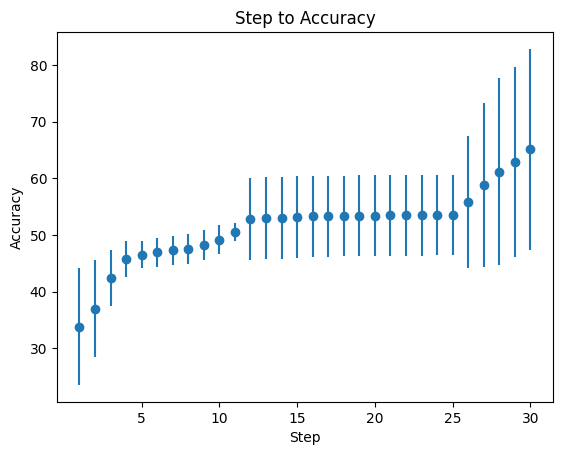

In [21]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [22]:
opro_results[str(len(opro_results))]

{'Please check the following sentence and correct any missing punctuation and grammatical errors. Output the punctuated text without omitting any words: "{TEXT}". Only provide the corrected text.': 95.78383441300069,
 'Please check the following text for missing punctuation. Return only the punctuated text, ensuring no omissions or rearrangements:\n\n{TEXT}.': 95.73365860861722,
 'Please properly punctuate and output the following text. Kindly output the resulting punctuated text without skipping any words:\n\n{TEXT}.\nRefrain from adding or removing any words, maintaining consistency and clearness in the punctuated text, and observe all the grammatical rules.': 94.96087807664433,
 'Correct punctuation and grammar of the text, output only corrected text skipping no words:("{TEXT}").': 92.47636074386868,
 '"Considering your request, I\'d like to submit "Please properly punctuate the following text and output only the resulting punctuated text, without omitting a single word.\n\n{TEXT}."

In [23]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please properly punctuate the given text (without omitting a single word) and output only the resulting punctu…

Initial Prompt: 31.06516230697552


Please check the following sentence and correct any missing punctuation and grammatical errors. Output the pun…

Optimized Prompt (Please check the following sentence and correct any missing punctuation and grammatical errors. Output the punctuated text without omitting any words: "{TEXT}". Only provide the corrected text.): 84.07777902332688


In [24]:
from datasets import Dataset
import pandas as pd
original_dataset = pd.read_csv("Grammar Correction.csv")
original_dataset[original_dataset["Error Type"] == "Punctuation Errors"]
original_dataset = original_dataset[original_dataset["Error Type"] == "Punctuation Errors"][["Ungrammatical Statement", "Standard English"]]
# Rename the columns
original_dataset.columns = ["text", "correction"]
# Convert to Dataset
original_dataset = Dataset.from_pandas(original_dataset)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, original_dataset)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, original_dataset)}")

Please properly punctuate the given text (without omitting a single word) and output only the resulting punctu…

Initial Prompt: 61.70009783923551


Please check the following sentence and correct any missing punctuation and grammatical errors. Output the pun…

Optimized Prompt (Please check the following sentence and correct any missing punctuation and grammatical errors. Output the punctuated text without omitting any words: "{TEXT}". Only provide the corrected text.): 67.33555318322296
